<a href="https://colab.research.google.com/github/jovanape/Bitcoint-Price-Prediction/blob/main/rnn_filtered_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predvidjanje vrednosti Bitcoina pomocu RNN**

**Atributi:** Open, High, Low, Close

**Filtrirani podaci:** od 28.11.2020.

## **Ucitavanje biblioteka**

In [1]:
# Ucitavanje biblioteka

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

## **Ucitavanje skupa podataka i pretprocesiranje**

In [2]:
# Ucitavanje skupa podataka

data = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Ciscenje podataka od NaN vrednosti

data = data.dropna()
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


In [4]:
# Kreiranje datuma

data['Date'] = pd.to_datetime(data['Timestamp'], unit='s').dt.date # samo datum (bez vremena)


# Filtriranje podataka

data = data.loc[data['Date'] > pd.to_datetime('2020-11-28')]
data.head(4)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
4681696,1606608000,17724.41,17724.41,17724.41,17724.41,0.016841,298.499979,17724.410000,2020-11-29
4681697,1606608060,17722.10,17749.65,17722.10,17749.65,2.859834,50688.152648,17724.156252,2020-11-29
4681698,1606608120,17763.62,17776.29,17755.76,17765.82,0.882884,15681.028780,17761.133523,2020-11-29
4681699,1606608180,17755.57,17755.90,17716.96,17716.96,1.407406,24977.798082,17747.400469,2020-11-29


In [5]:
# Dimenzije DataFrame-a

data.shape

(175515, 9)

## **Podela skupa, vizualizacija, priprema trening skupa**



### **Podela skupa podataka**

In [6]:
# Definicija funkcije za podelu podataka na train i test skup

def data_split(data, test_size = 0, days_to_predict = 0):

  if test_size == 0 and days_to_predict == 0:
    print('Uneti vrednost za jedan od parametara test_size ili days_to_predict.\n')
    return
  elif test_size == 0: # dato je days_to_predict
    test_limit = len(data) - prediction_days
  else: # dato je test_size ili oba parametra
    test_limit = len(data) - int(test_size * len(data))

  train = data[:test_limit]
  test = data[test_limit:]
  
  return train, test

In [7]:
# Podela inicijalnog skupa podataka na train i test skup

train, test = data_split(data, test_size = 0.2, days_to_predict = 0)

In [8]:
# Dimenzije train i test skupa

train.shape, test.shape

((140412, 9), (35103, 9))

### **Vizualizacija podataka**

In [9]:
# Definicija funkcije za vizuelni prikaz train i test podataka

def plot_data(train_data = train['Close'], test_data = test['Close']):

  fig, ax = plt.subplots(1, figsize=(16, 9))
  ax.plot(train_data, label='trening', linewidth=2)
  ax.plot(test_data, label='test', linewidth=2)
  ax.set_ylabel('cena [USD]', fontsize=14)
  ax.set_title(label = 'Vizuelni prikaz skupova za trening i test', fontsize=18)
  ax.legend(loc='best', fontsize=18)

  #data = data.reset_index()
  #x = data.index
  #ax.set_xticks(range(87724))


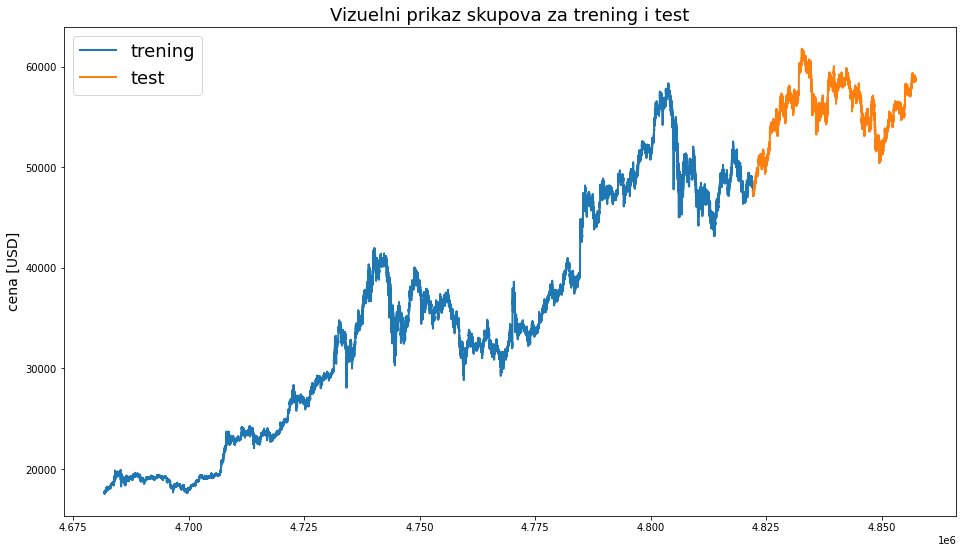

In [10]:
# Plotovanje train i test skupa podataka

plot_data(train_data = train['Close'], test_data = test['Close'])

### **Priprema trening skupa**

**Filtriranje atributa train skupa**

In [11]:
# Izbacivanje nepotrebnih kolona (atributa) iz train skupa

train_ = train.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
train_.head()

,Open,High,Low,Close
4681696,17724.41,17724.41,17724.41,17724.41
4681697,17722.10,17749.65,17722.10,17749.65
4681698,17763.62,17776.29,17755.76,17765.82
4681699,17755.57,17755.90,17716.96,17716.96
4681700,17724.70,17739.03,17724.70,17730.01


In [12]:
# Dimenzije train skupa - pre i nakon izbacivanja atributa

train.shape, train_.shape

((140412, 9), (140412, 4))

**Skaliranje train skupa**

In [13]:
# Skaliranje trening skupa

scaler = MinMaxScaler(feature_range=(0, 1))
train_ = scaler.fit_transform(train_)
train_

array([[0.00447337, 0.00395796, 0.00464653, 0.00423064],
       [0.00441676, 0.00457672, 0.00458991, 0.00484923],
       [0.00543432, 0.00522981, 0.00541507, 0.00524553],
       ...,
       [0.73070455, 0.73145812, 0.73008939, 0.73153164],
       [0.73138096, 0.73119017, 0.73112734, 0.73124244],
       [0.73122191, 0.73118919, 0.73109866, 0.73049297]])

**Odredjivanje ciljne promenljive na train skupu**

In [14]:
# Odredjivanje ciljne promenljive na train skupu

X_train = []
y_train = []

for i in range(60, train_.shape[0]):
    X_train.append(train_[i-60:i])
    y_train.append(train_[i,0])

In [15]:
# Konverzija u np.array

X_train, y_train = np.array(X_train), np.array(y_train)

In [16]:
# Dimenzije X_train

X_train.shape

(140352, 60, 4)

## **Kreiranje, kompilacija i treniranje mreze**

### **Kreiranje mreze**

In [17]:
# Definicija funkcije koja kreira i vraca model mreze

def build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2]):

  net = Sequential()
  net.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (input_1, input_2)))
  net.add(Dropout(0.2))
  net.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.3))

  net.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.4))

  net.add(LSTM(units = 120, activation = 'relu'))
  net.add(Dropout(0.5))

  net.add(Dense(units =1))
  print(net.summary())

  return net


In [18]:
# Kreiranje modela mreze

net = build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            11000     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

### **Kompilacija i treniranje mreze**

In [19]:
# Definicija funkcije za kompilaciju i treniranje mreze
# Treniranje je moguce vrsiti sa ili bez validacije

def compile_and_fit(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'mse', X_train_ = X_train, y_train_ = y_train, epochs = 20, validation = 0.1, batch_size = 50, patience = 3):

  net.compile(optimizer = optimizer, loss = loss, metrics = [metrics])

  callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = patience)
  # This callback will stop the training when there is no improvement in
  # the loss for three consecutive epochs.

  if validation == 0:
    history = net.fit(X_train_, y_train_, epochs = epochs, batch_size = batch_size, callbacks=[callback], verbose=0)
  else:
    history = net.fit(X_train_, y_train_, epochs = epochs, validation_split = validation, batch_size = batch_size, callbacks=[callback], verbose=0)

  return history, net


In [ ]:
# Kompilacija i treniranje mreze sa validacijom

print('Treniranje sa validacijom\n')
history_validation, net_validation = compile_and_fit(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'mse', X_train_ = X_train, y_train_ = y_train, epochs = 20, validation = 0.2, batch_size = 50, patience = 3)


# Kompilacija i treniranje mreze bez validacije

print('\nTreniranje bez validacije\n')
history_no_validation, net_no_validation = compile_and_fit(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'mse', X_train_ = X_train, y_train_ = y_train, epochs = 20, validation = 0, batch_size = 50, patience = 3)


Treniranje sa validacijom

Epoch 1/20
2246/2246 [==============================] - 482s 212ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 2/20
2246/2246 [==============================] - 480s 214ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 3/20
2246/2246 [==============================] - 480s 214ms/step - loss: 9.8233e-04 - mse: 9.8233e-04 - val_loss: 1.5919 - val_mse: 1.5919
Epoch 4/20
2246/2246 [==============================] - 481s 214ms/step - loss: 9.5035e-04 - mse: 9.5035e-04 - val_loss: 1.1580 - val_mse: 1.1580
Epoch 5/20
2246/2246 [==============================] - 480s 214ms/step - loss: 9.2634e-04 - mse: 9.2634e-04 - val_loss: 0.5844 - val_mse: 0.5844
Epoch 6/20
2246/2246 [==============================] - 478s 213ms/step - loss: 9.1878e-04 - mse: 9.1878e-04 - val_loss: 0.0623 - val_mse: 0.0623
Epoch 7/20
2246/2246 [==============================] - 482s 215ms/step - loss: 8.9609e-04 - mse: 8.9609e-04 - va

## **Priprema test skupa**

### **Filtriranje atributa test skupa**

In [ ]:
# Izbacivanje nepotrebnih kolona (atributa) iz test skupa

test_ = test.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)


### **Skaliranje test skupa**

In [ ]:
# Skaliranje test skupa

test_ = scaler.transform(test_)

### **Odredjivanje ciljne promenljive na test skupu**

In [ ]:
# Odredjivanje ciljne (target) promenljive na test skupu

X_test = []
y_test = []

for i in range(60, test_.shape[0]):
    X_test.append(test_[i-60:i])
    y_test.append(test_[i,0])
    

In [ ]:
# Konverzija u np.array

X_test, y_test = np.array(X_test), np.array(y_test)

## **Predvidjanje**

In [ ]:
# Predvidjanje za mrezu treniranu bez i sa validacijom

# Bez validacije
y_predicted_no_validation = net_no_validation.predict(X_test)
print('Predvidjene vrednosti - bez validacije:\n', y_predicted_no_validation)

print('R2 Score: ', r2_score(y_test, y_predicted_no_validation))
print('MAE: ', mean_absolute_error(y_test, y_predicted_no_validation))

# Sa validacijom
y_predicted_validation = net_validation.predict(X_test)
print('\nPredvidjene vrednosti - sa validacijom:\n', y_predicted_validation)

print('R2 Score: ', r2_score(y_test, y_predicted_validation))
print('MAE: ', mean_absolute_error(y_test, y_predicted_validation))

## **Vizualizacija rezultata predvidjanja i metrika**

In [ ]:
# Vizuelni prikaz rezultata modela mreze

def plot_real_vs_predicted_data(test_set, predicted_set):

  fig, ax = plt.subplots(1, figsize=(16, 9))
  ax.plot(test_set, label='Stvarna vrednost BTC', linewidth=2)
  ax.plot(predicted_set, label='Predvidjena vrednost BTC', linewidth=2)
  ax.set_xlabel('Redni broj instance', fontsize=14)
  ax.set_ylabel('Cena [USD]', fontsize=14)
  ax.set_title(label = 'Vizuelni prikaz stvarne i predvidjene vrednosti BTC', fontsize=18)
  ax.legend(loc='best', fontsize=18)

  # test = test.reset_index()
  # x = test.index


In [ ]:
# Plotovanje stvarne i predvidjene vrednosti

# Bez validacije

print('Bez validacije\n')
plot_real_vs_predicted_data(test_set = y_test, predicted_set = y_predicted_no_validation)


# Sa validacijom

print('\nSa validacijom\n')
plot_real_vs_predicted_data(test_set = y_test, predicted_set = y_predicted_validation)

In [ ]:
# Vizuelni prikaz gubitka i MSE tokom treniranja mreze

# Ukoliko je validacija nije koriscena tokom treniranja mreze,
# onda parametar is_validation_used treba biti 0, a inace 1

def plot_loss_and_mse(history_, is_validation_used):

  epochs = range(len(history_.history['loss'])) # broj epoha

  plt.title('Vizuelni prikaz gubitka (loss) i srednjekvadratna greska (mse) mreze')


  # Gubitak

  plt.subplot(211)
  
  plt.plot(epochs, history_.history['loss'], label='Gubitak (loss) tokom treniranja')

  if is_validation_used == 1:
    plt.plot(epochs, history_.history['val_loss'], label='Gubitak (val_loss) tokom validacije')
  
  plt.legend()


  # MSE

  plt.subplot(212)

  plt.plot(epochs, history_.history['accuracy'], label='Srednjekvadratna greska (mse) tokom treniranja')
  
  if is_validation_used == 1:
    plt.plot(epochs, history_.history['val_mse'], label='Srednjekvadratna greska (val_mse) tokom validacije')
  
  plt.legend()

  plt.show()


In [ ]:
# Plotovanje gubitka i srednjekvadratne greske mreze tokom treniranja

# Bez validacije

print('Bez validacije\n')
plot_loss_and_mse(history_ = history_no_validation, is_validation_used = 0)


# Sa validacijom

print('\nSa validacijom\n')
plot_loss_and_mse(history_ = history_validation, is_validation_used = 1)